# Siamese Network Tutorial

In this notebook i will walk through the creation of a Siamese Neural Network, which is often used for tasks like image similarity (signature verification, face matching, ...), text similarity, and one-shot learning.

In this case, we will use the MNIST dataset to build the network, which will compare pairs of images and determine whether they belong to the same class or not.

## Step 1: Import Required Libraries
We will start by importing necessary libraries for data manipulation, neural networks, and visualization.

In [1]:
import random
from datetime import datetime

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch import optim
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter
import torchvision.transforms as transforms
from torchvision.datasets import MNIST



## Setup Training

In [2]:
EPOCHS = 10
EMBEDDING_SPACE = 3
current_time = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
# tensorboard log dir
log_dir = f'runs/siamese_network_{current_time}'
writer = SummaryWriter(log_dir=log_dir)
print(log_dir)

runs/siamese_network_2024-10-04_03-30-48


## Step 2: Set Up Device
Here, we define whether we will be using a GPU (CUDA) or CPU for our computations. If a GPU is available, it will be used.

In [3]:
try:
    import torch_xla.core.xla_model as xm
    device = xm.xla_device()  # Define a TPU
except ImportError:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Step 3: Create a Custom Dataset for Siamese Networks
We will now create a custom dataset class `SiameseDataset`. This dataset will provide pairs of images from the MNIST dataset, where each pair will either belong to the same class or to different classes. The label will indicate whether the images are similar (0 for same class, 1 for different classes).

In [4]:
class SiameseDataset(Dataset):
    def __init__(self, data, transform=None):
        """
        Initializes the SiameseDataset class.
        
        Args:
            data: List of tuples where each tuple contains (image, label).
            transform: Optional transform to be applied on a sample.
        """
        self.data = data  # Store the dataset.
        self.transform = transform  # Store the image transformation function.

    def _get_image_from_same_class(self, labelA):
        labelB = -1
        while labelB != labelA:
            imgB, labelB = random.choice(self.data)
        return imgB, labelB
    
    def _get_image_from_different_class(self, labelA):
        labelB = labelA
        while labelB == labelA:
            imgB, labelB = random.choice(self.data)
        return imgB, labelB
    
    def __getitem__(self, index):
        """
        Returns a sample from the dataset, consisting of two images and a label indicating
        if they belong to the same class.
        
        Args:
            index: Index of the first image in the dataset.
        
        Returns:
            imgA, imgB: A pair of images.
            label: A binary tensor indicating whether the images are from the same class (0) 
                   or different classes (1).
        """
        imgA, labelA = self.data[index]
        same_class_flag = random.randint(0, 1)

        if same_class_flag:
            imgB, labelB = self._get_image_from_same_class(labelA)
        else:
            imgB, labelB = self._get_image_from_different_class(labelA)

        if self.transform:
            imgA = self.transform(imgA)
            imgB = self.transform(imgB)

        return imgA, imgB, torch.tensor([labelA != labelB], dtype=torch.float32)

    def __len__(self):
        return len(self.data)
    

mnist_train = MNIST(root='./data', train=True, download=True)
mnist_test = MNIST(root='./data', train=False, download=True)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomRotation(degrees=15)
])

siamese_train = SiameseDataset(mnist_train, transform)
siamese_test = SiameseDataset(mnist_test, transform)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:01<00:00, 5458834.43it/s] 


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 157417.83it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1509669.90it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 1815200.45it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



## Step 4: Visualize the Dataset
Let's visualize a few samples of image pairs from our custom `SiameseDataset`. This will help us understand how the pairs are generated (same class or different class).

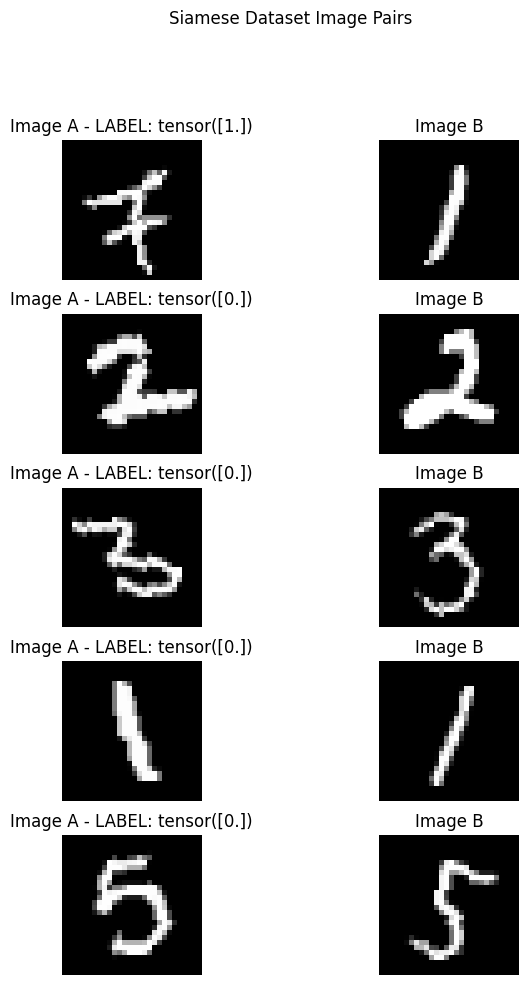

In [5]:
def plot_siamese_samples(dataset, num_samples=5):
    """
    Plots pairs of images from the SiameseDataset along with their label indicating
    if they belong to the same class or different classes.
    
    Args:
        dataset: An instance of the SiameseDataset.
        num_samples: Number of image pairs to plot.
    """
    fig, axes = plt.subplots(num_samples, 2, figsize=(8, num_samples * 2))
    fig.suptitle('Siamese Dataset Image Pairs')

    for i in range(num_samples):
        imgA, imgB, label = dataset[random.randint(0, len(dataset)-1)]
        imgA = imgA.cpu().squeeze().numpy()
        imgB = imgB.cpu().squeeze().numpy()

        axes[i, 0].imshow(imgA, cmap='gray')
        axes[i, 0].axis('off')
        axes[i, 0].set_title(f'Image A - LABEL: {label}')

        axes[i, 1].imshow(imgB, cmap='gray')
        axes[i, 1].axis('off')
        axes[i, 1].set_title('Image B')

    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.savefig('plot_siamese_samples.png')

# Example usage:
plot_siamese_samples(siamese_train, num_samples=5)

## Step 5: Build the Siamese Network Architecture
The `SiameseNetwork` consists of two branches that share weights. These branches process the two input images, and the results are compared to determine the similarity. The architecture consists of convolutional layers followed by fully connected layers.
import torch.nn as nn

In [6]:
class Tower(nn.Module):
    """
    This is the embedding generator.
    """
    def __init__(self):
        super(Tower, self).__init__()

        self.cnn = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),

            nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2)
        )

        self.fc = nn.Sequential(
            nn.Linear(256 * 3 * 3, 1024),
            nn.ReLU(inplace=True),

            nn.Linear(1024, 256),
            nn.ReLU(inplace=True),

            nn.Linear(256, EMBEDDING_SPACE)
        )

    def forward(self, x):
        output = self.cnn(x)
        output = output.view(output.size()[0], -1)
        output = self.fc(output)
        return output

In [7]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.tower = Tower()  # Shared tower network

    def forward(self, inputA, inputB):
        outputA = self.tower(inputA)
        outputB = self.tower(inputB)
        return outputA, outputB

## Step 6: Define the Contrastive Loss Function
We use the contrastive loss function to optimize the Siamese Network. This loss function computes the distance between two outputs and penalizes the network based on whether they are from the same class or not.

- **The margin forces samples from different classes to be at least a certain distance apart**; if the euclidean_distance < margin, the difference is positive, penalizing the model, with the penalty increasing as the distance decreases.
- **A lower loss** indicates that embeddings of the same class are close together, and embeddings of different classes are appropriately separated.
- **A higher loss** would indicate that embeddings of the same class are far apart or that embeddings of different classes are too close.

In [8]:
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=3.0):
        # The margin is the threshold
        # that determines how far apart the embeddings
        # of different classes should be.
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, outputA, outputB, label):
        # The forward method defines the computation of the contrastive loss.
        # It receives two outputs (outputA, outputB) and a label (1 or 0).
        # 'outputA' and 'outputB' represent the embeddings for two input samples.

        # Compute the Euclidean distance between the two outputs (embeddings).
        euclidean_distance = F.pairwise_distance(outputA, outputB, keepdim=True)

        # Loss for pairs that belong to the same class (label = 0). This encourages embeddings
        # from the same class to be close to each other by minimizing the squared distance.
        same_class_loss = (1 - label) * (euclidean_distance ** 2)

        # Loss for pairs that belong to different classes (label = 1). This encourages embeddings
        # from different classes to be separated by at least 'margin' by penalizing distances 
        # below the margin. The clamp ensures the difference doesn't go below 0.
        diff_class_loss = (label) * (torch.clamp(self.margin - euclidean_distance, min=0.0) ** 2)

        # Return the average loss across the batch.
        return torch.mean(same_class_loss + diff_class_loss)

## Step 7: Training the Network
Now we will train the network using the `SiameseDataset` and the `ContrastiveLoss`. The training loop involves computing the loss for each image pair and updating the model parameters.

In [9]:
train_dataloader = DataLoader(siamese_train, shuffle=True, batch_size=256)

model = SiameseNetwork().to(device)
criterion = ContrastiveLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(EPOCHS):
    total_loss = 0
    
    for batch_idx, (imgA, imgB, label) in enumerate(tqdm(train_dataloader, desc=f"Train epoch: {epoch+1}")):
        imgA, imgB, label = imgA.to(device), imgB.to(device), label.to(device)
        optimizer.zero_grad()
        outputA, outputB = model(imgA, imgB)
        loss_contrastive = criterion(outputA, outputB, label)
        loss_contrastive.backward()

        total_loss += loss_contrastive.item()
        optimizer.step()
        writer.add_scalar('Loss/batch', loss_contrastive.item(), epoch * len(train_dataloader) + batch_idx)
    avg_loss = total_loss / batch_idx
    writer.add_scalar('Loss/avg_epoch', avg_loss, epoch)
    print(f"Epoch {epoch}; Loss {total_loss}")
writer.close()

Train epoch: 1: 100%|██████████| 235/235 [01:30<00:00,  2.59it/s]


Epoch 0; Loss 209.12132069468498


Train epoch: 2: 100%|██████████| 235/235 [01:29<00:00,  2.63it/s]


Epoch 1; Loss 69.50413423776627


Train epoch: 3: 100%|██████████| 235/235 [01:29<00:00,  2.62it/s]


Epoch 2; Loss 42.60484366863966


Train epoch: 4: 100%|██████████| 235/235 [01:29<00:00,  2.61it/s]


Epoch 3; Loss 30.188834872096777


Train epoch: 5: 100%|██████████| 235/235 [01:29<00:00,  2.64it/s]


Epoch 4; Loss 25.28148839622736


Train epoch: 6: 100%|██████████| 235/235 [01:29<00:00,  2.61it/s]


Epoch 5; Loss 21.58378036133945


Train epoch: 7: 100%|██████████| 235/235 [01:30<00:00,  2.61it/s]


Epoch 6; Loss 17.99318927899003


Train epoch: 8: 100%|██████████| 235/235 [01:28<00:00,  2.65it/s]


Epoch 7; Loss 17.90443094447255


Train epoch: 9: 100%|██████████| 235/235 [01:31<00:00,  2.57it/s]


Epoch 8; Loss 15.07157820649445


Train epoch: 10: 100%|██████████| 235/235 [01:32<00:00,  2.55it/s]

Epoch 9; Loss 14.072392188943923


In [10]:

def evaluate_model(model, dataloader):
    model.eval()  # Set the model to evaluation mode
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for imgA, imgB, label in dataloader:
            imgA, imgB, label = imgA.to(device), imgB.to(device), label.to(device)
            outputA, outputB = model(imgA, imgB)
            euclidean_distance = F.pairwise_distance(outputA, outputB)
            predictions = euclidean_distance > 1.0  # Threshold for same/different class
            total_correct += (predictions == label).sum().item()
            total_samples += label.size(0)

    accuracy = total_correct / total_samples
    return accuracy

test_dataloader = DataLoader(siamese_test, shuffle=False, batch_size=64)
accuracy = evaluate_model(model, test_dataloader)
print(f'Test Dataset Accuracy: {accuracy}%')


Test Dataset Accuracy: 32.457%


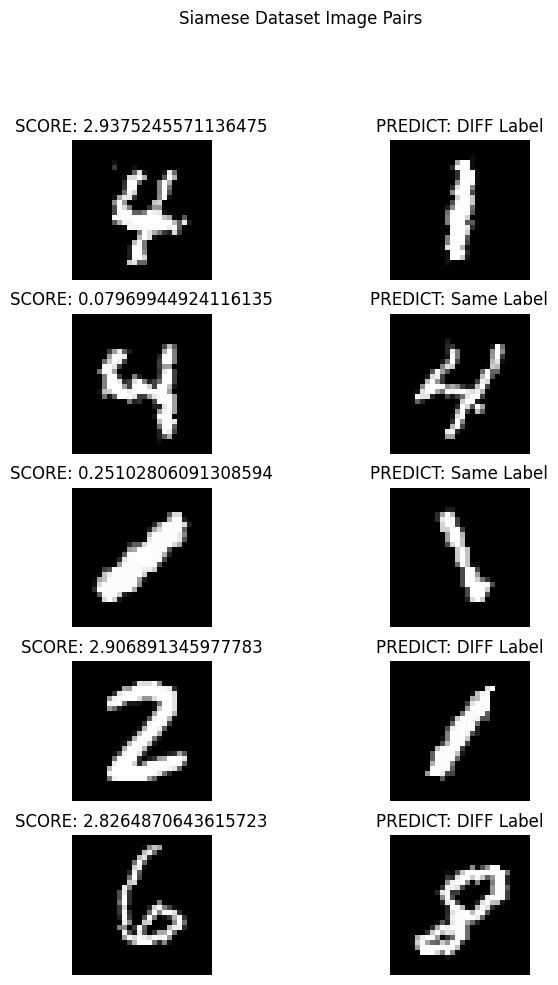

In [11]:

def plot_siamese_predict_samples(dataset, num_samples=5):
    """
    Plots pairs of images from the SiameseDataset along with their label indicating
    if they belong to the same class or different classes.
    
    Args:
        dataset: An instance of the SiameseDataset.
        num_samples: Number of image pairs to plot.
    """
    # Set up the plot with 2 columns for image pairs
    fig, axes = plt.subplots(num_samples, 2, figsize=(8, num_samples * 2))
    fig.suptitle('Siamese Dataset Image Pairs')

    for i in range(num_samples):
        # Randomly pick an index from the dataset
        imgA, imgB, label = dataset[random.randint(0, len(dataset)-1)]
        imgA, imgB, label = imgA.to(device), imgB.to(device), label.to(device)
        outputA, outputB = model(imgA.unsqueeze(0), imgB.unsqueeze(0))
        similarity_score = F.pairwise_distance(outputA, outputB).cpu().item()

        # Convert tensors to numpy arrays for plotting
        # Move tensors to CPU before converting to NumPy arrays
        imgA = imgA.cpu().squeeze().numpy()  # Changed line
        imgB = imgB.cpu().squeeze().numpy()  # Changed line

        # Display first image (imgA)
        axes[i, 0].imshow(imgA, cmap='gray')
        axes[i, 0].axis('off')
        axes[i, 0].set_title(f'SCORE: {similarity_score}')
        PRED_LABEL = 'Same Label' if similarity_score < .35 else 'DIFF Label'
        # Display second image (imgB)
        axes[i, 1].imshow(imgB, cmap='gray')
        axes[i, 1].axis('off')
        axes[i, 1].set_title(f'PREDICT: {PRED_LABEL}')

    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.savefig('plot_siamese_predict_samples.png')


plot_siamese_predict_samples(siamese_test, num_samples=5)

## Save the Model

In [12]:
# Salvar o modelo da Tower
torch.save(model.tower, 'tower_model_siamese.pth')

## Step 8: Load the Network
Let's test the network on a few image pairs from the test dataset and visualize the similarity scores.

```python
import torch.nn as nn
from torchvision.datasets import MNIST
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
```

In [13]:
tower_model = torch.load('tower_model_siamese.pth', map_location=device)
tower_model.eval()  # Eval mode

/tmp/ipykernel_23/392343463.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  tower_model = torch.load('tower_model_siamese.pth', map_location=device)


Tower(
  (cnn): Sequential(
    (0): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=2304, out_features=1024, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=1024, out_features=256, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=256, out_features=3, bias=True)
  )
)

## Step 8: Test the Network
Let's test the network on a few image pairs from the test dataset and visualize the similarity scores.

In [14]:
mnist_test = MNIST(root='./data', train=False, download=True)
test_tensor = torch.utils.data.TensorDataset(torch.tensor(mnist_test.data), torch.tensor(mnist_test.targets))
# Create a data loader from the tensor dataset
test_loader = torch.utils.data.DataLoader(test_tensor, batch_size=1, shuffle=False)


# EVAL USANDO TOWER:
for imgA, label in test_tensor:
    imgA = imgA.type(torch.float32).unsqueeze(0).unsqueeze(0).to(device)  
    outputA = tower_model(imgA)
    print(outputA)
    break

for imgA, label in test_loader:
    imgA = imgA.type(torch.float32).unsqueeze(0).to(device)  
    outputA = tower_model(imgA)
    print(outputA)
    break

tensor([[ 50.5933,  25.6803, 236.7895]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
tensor([[ 50.5933,  25.6803, 236.7895]], device='cuda:0',
       grad_fn=<AddmmBackward0>)


/tmp/ipykernel_23/2248407945.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_tensor = torch.utils.data.TensorDataset(torch.tensor(mnist_test.data), torch.tensor(mnist_test.targets))


In [15]:

## Visualize the embeddings.
from sklearn.manifold import TSNE

# Define a function to extract embeddings from the tower model
# Create a data loader from the tensor dataset
# Define a function to extract embeddings from the tower model
def extract_embeddings(loader, model, device):
    embeddings = []
    labels = []
    with torch.no_grad():
        for x, y in loader:
            x = x.type(torch.float32)
            x = x.to(device)
            output = model(x.unsqueeze(0))
            embeddings.append(output.cpu().numpy())
            labels.append(y.cpu().numpy())
    return np.concatenate(embeddings), np.concatenate(labels)

embeddings, labels = extract_embeddings(test_loader, tower_model, device)

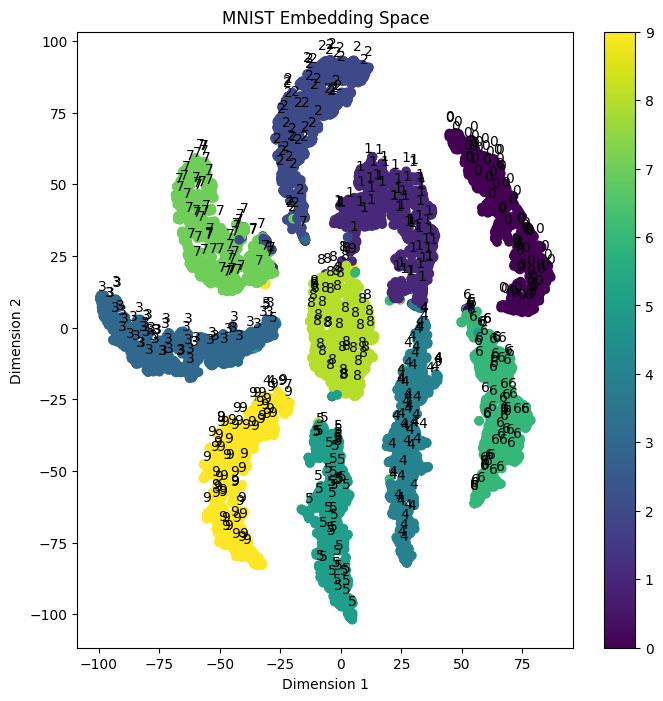

In [16]:
# Use t-SNE to reduce the dimensionality of the embeddings
def visualizate_embeddings(embeddings, labels, annotation_sample=.06):
    # Use t-SNE to reduce the dimensionality of the embeddings
    tsne = TSNE(n_components=2, random_state=42)
    embeddings_2d = tsne.fit_transform(embeddings)

    # Plot the embedding space
    plt.figure(figsize=(8, 8))
    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels)

    # Sample x% of the labels for annotation
    sample_idx = np.random.choice(range(len(labels)), size=int(annotation_sample * len(labels)), replace=False)
    for i in sample_idx:
        x, y = embeddings_2d[i, 0], embeddings_2d[i, 1]
        plt.annotate(str(labels[i]), (x, y), textcoords="offset points", xytext=(0,10), ha='center')

    plt.title('MNIST Embedding Space')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.colorbar()
    plt.savefig('ContrastiveLoss - MNIST Embedding Space.png')

visualizate_embeddings(embeddings, labels)

In [17]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

# Directly put the log path in the logdir param
%tensorboard --logdir="runs/"